In [17]:
### IMPORTS ###

import cv2 as cv
import matplotlib.pyplot as plt 
import numpy as np
from hermite_func import *

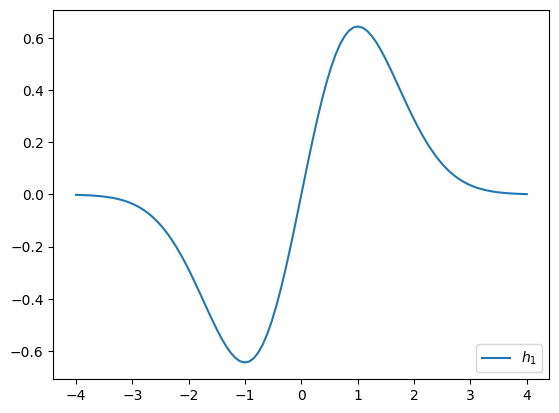

In [18]:
x = np.linspace(-4, +4, 100)
n = 1
f = hermite_functions(n, x, all_n=False)
plt.plot(x, f, label=f'$h_{n}$')
plt.legend(loc='lower right')
plt.show()

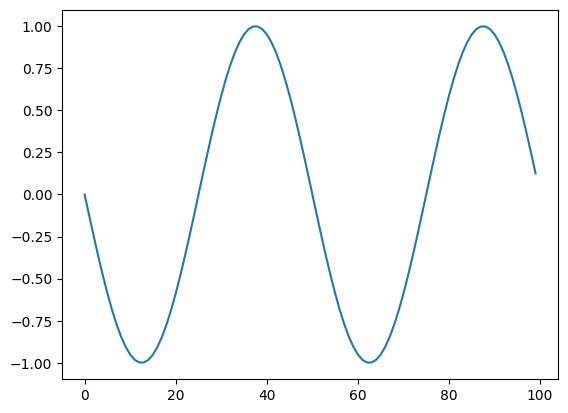

In [19]:
import matplotlib.pyplot as plt 
N = 100
# create data of complex numbers 
data = [np.sin(-2*np.pi * 2 * x / N) for x in range(N)] 
  
# extract real part 
x = [ele.real for ele in data] 
# extract imaginary part 
y = [ele.imag for ele in data] 
  
# plot the complex numbers 
# plt.scatter(x, y) 
# plt.ylabel('Imaginary') 
# plt.xlabel('Real') 
# plt.show() 
plt.plot(data, label=f'$h_{n}$')

<class 'numpy.ndarray'>


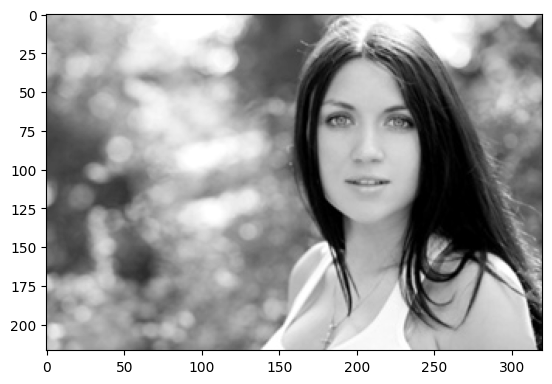

In [20]:
im = cv.imread("girl.jpg", flags=cv.IMREAD_GRAYSCALE)
im = im.astype(np.int32)
print(type(im))
plt.imshow(im, cmap='gray')

In [61]:
def move_coord(x: float, fshape: int, A_N: int):
    '''
    Perform coordination transform to mode f from [0; fshape] to [-A_N; A_N]
    '''
    return int(np.round(x + 5) * (fshape-1) / (2* A_N))

def hermite_localization(N: int) -> int:
    '''
    Calculates localization interval for Hermite function of N-th degree. \n
    Params:\n
    - N (int) - degree of Hermite function
    '''
    A_N = np.sqrt(2 * N + 1)
    return int(np.ceil(A_N))


def function_baseline(N: int, f: np.ndarray) -> np.ndarray:
    ''' 
    Calculate 'base line' for image row. \n
    Params: \n
    - N (int) - degree of Hermite function
    - f (np.ndarray) - row of image (array of shape (K,))
    '''
    # get localization of Hermite function (center in zero)
    A_N = hermite_localization(N)
    # move coordinate of f
    A_N_m = move_coord(A_N, f.shape[0], A_N)
    # calculate L_b with moved center of function
    L_b_fun = lambda x : f[A_N_m] + 1/(2 * (A_N)) * (f[A_N_m] - f[-A_N_m]) * (x + A_N)
    L_b = np.array([L_b_fun(x) for x in np.linspace(-A_N, A_N, f.shape[0])])
    return L_b

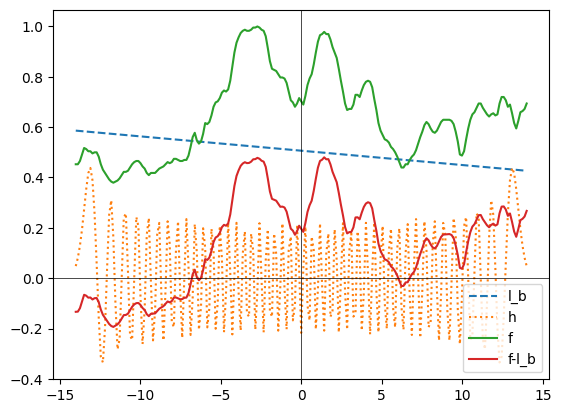

In [76]:
f = im[:,135] / np.max(im[:,135])
n = 90
A_n = hermite_localization(n)
x = np.linspace(-A_n, A_n, f.shape[0])
h = hermite_functions(n, x, all_n=False)
l_b = function_baseline(n, f)
plt.plot(x, l_b, '--', label="l_b")
plt.plot(x, h, ':', label="h")
plt.plot(x, f, label="f")
plt.plot(x, f - l_b,  label="f-l_b")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend(loc='lower right')
plt.show()

In [63]:
def preprocess_image(img: np.ndarray, N: int = 100) -> np.ndarray:
    '''
    Applies transforms to image before Hermite decomposition such as 
    - normalization to [0;1]
    - baseline preprocess.
    '''
    img = img / np.max(img)
    img = baseline_transform(img, N)
    return img

def baseline_transform(img: np.ndarray, N: int) -> np.ndarray:
    '''
    Applies baseline transform to image by rows. 
    '''
    row_baseline_transform = lambda x : x - function_baseline(N, x)
    return np.apply_along_axis(row_baseline_transform, 1, img)

255 1.3238305980699492 -1.4416620566721987


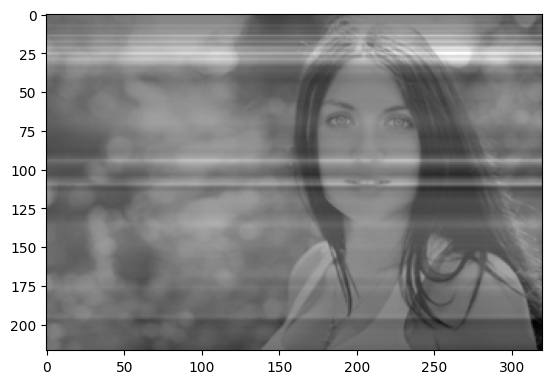

In [64]:
im_new = preprocess_image(im)
print(np.max(im), np.max(im_new), np.min(im_new))
plt.imshow(im_new, cmap='gray')

In [65]:
def hermite_coef(i : int, j : int, f : np.ndarray, return_hermite_func : bool = False) -> float:
    '''Calculates Hermite coefficient c_ij.'''
    # integration limits
    lim_x, lim_y = hermite_localization(i), hermite_localization(j)
    # grid 
    N_x, N_y = f.shape
    x = np.linspace(-lim_x, lim_x, N_x)
    y = np.linspace(-lim_y, lim_y, N_y)
    # grid step
    h_x = 2 * lim_x / N_x
    h_y = 2 * lim_y / N_y
    # hermite functions 
    psi_i = hermite_functions(i, x).reshape(-1,1)
    psi_j = hermite_functions(j, y).reshape(1,-1)
    # integral as sum 
    c = np.sum(f * psi_i * psi_j * h_x * h_y)
    if return_hermite_func:
        return psi_i, psi_j, c
    else:
        return c

def hermite_decomp(im: np.ndarray, M: int, N: int) -> np.ndarray:
    '''Performs Hermite decomposition of image.'''
    # calculate decomposition as sum of series
    decomp = np.zeros(im.shape)
    for i in range(M):
        for j in range(N):
            psi_i, psi_j, c = hermite_coef(i, j, im, True)
            decomp += c * psi_i * psi_j
    return decomp

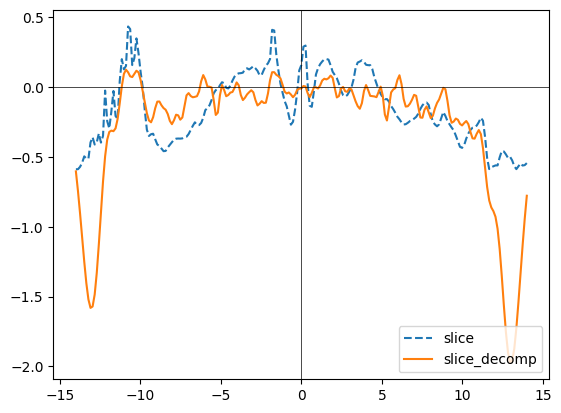

In [75]:
slice = im_new[:,135].reshape(-1,1)
n = 90
A_n = hermite_localization(n)
x = np.linspace(-A_n, A_n, slice.shape[0])
slice_decomp = hermite_decomp(slice, n, 1)[:,0]
plt.plot(x, slice, '--', label="slice")
plt.plot(x, slice_decomp, label="slice_decomp")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend(loc='lower right')
plt.show()